# Radiation Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 16

In [2]:
trip_attraction = np.loadtxt('../data/trip_attraction.txt')
trip_production = np.loadtxt('../data/trip_production.txt')
poi = np.loadtxt('../data/poi.txt')
pop = np.loadtxt('../data/pop.txt')
dist_cell = np.loadtxt('../data/dist_cell.txt')
od_census = np.loadtxt('../data/links.txt')

In [3]:
def ExtRadiation():
    m, n = np.shape(dist_cell)
    OD = np.zeros((m*(m-1), 4))
    OD_num = 0
    
    for i in range(m):
        prop = np.zeros((m,1))
        dist = np.zeros((m,1))
        for j in range(m):
            if i != j:
                dist[j] = dist_cell[i, j]
                index = np.where((dist_cell[i,:] < dist[j]) & (dist_cell[i,:] > 0))
                s = np.sum(D[index])
                prop[j] = (D[i]**alpha+1)*((D[i]+s+D[j])**alpha-(D[i]+s)**alpha)/(((D[i]+s)**alpha+1)*((D[i]+s+D[j])**alpha+1))
        for j in range(m):
            if i != j:
                OD[OD_num,0] = i
                OD[OD_num,1] = j
                OD[OD_num,2] = O[i]*prop[j] / np.sum(prop)
                OD[OD_num,3] = dist[j]
                OD_num += 1
    return OD

In [4]:
def lnbin(x, y, BinNum):
# This function take the input of a data vector x, which is to be binned;
# it also takes in the amount bins one would like the data binned into. The
# output is two vectors, one containing the normalised frequency of each bin 
# (Freq), the other, the midpoint of each bin (midpts).
# Added and error to the binned frequency: eFreq (As of June 30 2010). If this
# option is not required, just call the function without including the third out
# put; i.e.: [midpts Freq]=lnbin(x,BinNum). 

    x = np.sort(x)
    i=0
    while x[i] <= 0:
        i += 1

    FPT = x[i:]
    LFPT = np.log(FPT)
    max1 = np.log(np.max(FPT))
    min1 = np.log((np.min(FPT)))
    LFreq = np.zeros((BinNum, 1))
    LTime = np.zeros((BinNum, 1))
    Lends = np.zeros((BinNum, 2))

    step = (max1 - min1) / BinNum


    # ------------ LOG Binning Data ------------------------
    for i in range(len(FPT)):
        for k in range(BinNum):
            if( ((k) * step + min1 <= LFPT[i]) & (LFPT[i] < (k+1) * step + min1) ):
                LFreq[k] = LFreq[k] + y[i]
            LTime[k] = k * step - (0.5 * step) + min1
            Lends[k, 0] = (k - 1) * step + min1
            Lends[k, 1] = k * step + min1
    ends = np.exp(Lends)
    widths = ends[:len(ends), 1] - ends[:len(ends), 0]
    Freq = LFreq.T / widths / len(x)
    midpts = np.exp(LTime)
    return(midpts, Freq.T)

In [5]:
def CalcFlows(OD, marker, label):
    m, n = np.shape(OD)
    x = []
    y = []
    Fl = []
    Ds = []
    for i in range(m):
        if ((OD[i, 3] > 1.0) & (OD[i,2] > 0)):
            Fl.append(OD[i,2])
            Ds.append(OD[i,3])
    x, P = lnbin(Ds,Fl,25)
    plt.plot(x, P/sum(P), label=label, marker=marker, markersize=10)
    plt.legend()
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.xlabel('Distance (km), r', fontsize=20)
    plt.ylabel('P(r)', fontsize=20)
#     plt.loglog(x,P/sum(P),[color,marker],'MarkerEdgeColor',color,'MarkerSize',6,'MarkerFaceColor',color,'linewidth',0.75);
#     set(gca,'FontName','Times New Roman','FontSize',20)
#     plt.xlabel('Distance (km), r','FontName','Times New Roman','FontSize',20)
#     plt.ylabel('P(r)','FontName','Times New Roman','FontSize',20)


In [6]:
def CompareFlows(OD,OD_d):
    m, n = np.shape(OD_d)
    F_mod = []
    F_d = []
    for i in range(m):
        if ((OD_d[i, 2] > 0) & (OD_d[i, 3] > 0.1)): # threshold by distance
            F_d.append(OD_d[i, 2])
            index = np.where((OD[:,0] == OD_d[i, 0]) & (OD[:,1] == OD_d[i, 1]))
            F_mod.append(OD[index,2])
    F_mod = np.array(F_mod).reshape(-1,1)
    F_d = np.array(F_d).reshape(-1,1)
    ax = plt.gca()
    plt.scatter(F_d, F_mod, c='r', s=20, alpha=.1)
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.xlabel(r'$T_{ij}$ (Data)', fontsize=20)
    plt.ylabel(r'$T_{ij}$ (Radiation Model)', fontsize=20)
#     set(gca,'FontName','Times New Roman','FontSize',20)
#     xlabel('T_{ij} (Data)','FontName','Times New Roman','FontSize',20)
#     ylabel('T_{ij} (Radiation Model)','FontName','Times New Roman','FontSize',20)

    x = np.arange(np.min(F_d), np.max(F_mod))
    plt.plot(x,x,'k-')

    plt.xlim([np.min(F_d), np.max(F_mod)])
    plt.ylim([np.min(F_d), np.max(F_mod)])

In [7]:
def CPC(T_census, T_simulated):
    double = pd.concat([T_census, T_simulated], axis=1).min(axis=1)
    cpc = 2 * double.sum() / (T_census.sum() + T_simulated.sum())
    return cpc

In [8]:
# Set the value of alpha for the extended radiation model
# Better results with the median value

# l_caract_mean = 4.652791500542748           #km
l_caract_median = 3.1295916904198156
alpha = (l_caract_median / 36) ** 1.33
alpha

0.03882543125413137

CPC = 0.692404398379456
CPU times: user 6.74 s, sys: 53.5 ms, total: 6.8 s
Wall time: 6.65 s


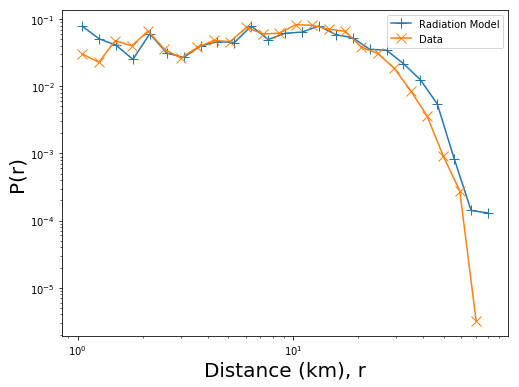

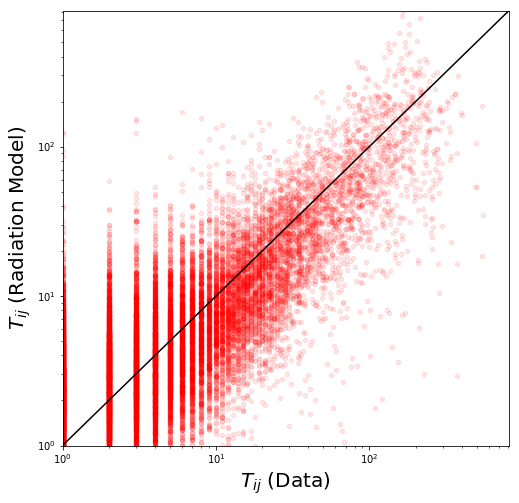

In [9]:
%%time

O = trip_production
D = trip_attraction

OD = ExtRadiation()

plt.figure(figsize=(8, 6))
CalcFlows(OD, '+', 'Radiation Model')
CalcFlows(od_census, 'x', 'Data')

plt.figure(figsize=(8,8))
CompareFlows(OD, od_census)

df_OD = pd.DataFrame(OD[:, :3], columns=['origin', 'destination', 'nb_of_trips'])
df_od_census = pd.DataFrame(od_census[:, :3], columns=['origin', 'destination', 'nb_of_trips'])
OD_gb_OD = df_OD.groupby(['origin', 'destination']).first()
od_census_gb_OD = df_od_census.groupby(['origin', 'destination']).first()

joint_ij = pd.merge(OD_gb_OD, od_census_gb_OD, right_index=True, left_index=True).rename(columns={'nb_of_trips_x':'nb_of_trips_OD', 'nb_of_trips_y':'nb_of_trips_od_census'})

CPC1 = CPC(joint_ij.nb_of_trips_od_census, joint_ij.nb_of_trips_OD)
print('CPC =', CPC1)

CPC = 0.6715794066024882
CPU times: user 7.82 s, sys: 66.4 ms, total: 7.89 s
Wall time: 7.68 s


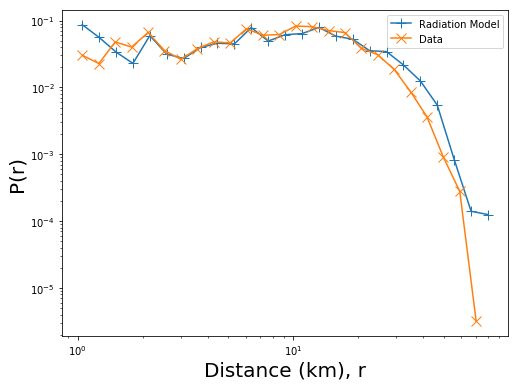

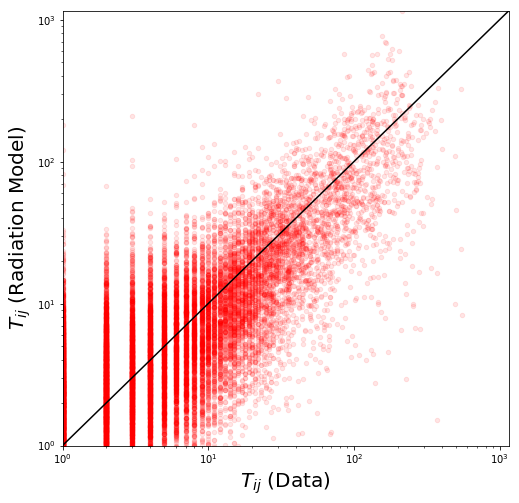

In [10]:
%%time

O = trip_production
D = poi

OD = ExtRadiation()

plt.figure(figsize=(8, 6))
CalcFlows(OD, '+', 'Radiation Model')
CalcFlows(od_census, 'x', 'Data')

plt.figure(figsize=(8,8))
CompareFlows(OD, od_census)

df_OD = pd.DataFrame(OD[:, :3], columns=['origin', 'destination', 'nb_of_trips'])
df_od_census = pd.DataFrame(od_census[:, :3], columns=['origin', 'destination', 'nb_of_trips'])
OD_gb_OD = df_OD.groupby(['origin', 'destination']).first()
od_census_gb_OD = df_od_census.groupby(['origin', 'destination']).first()
joint_ij = pd.merge(OD_gb_OD, od_census_gb_OD, right_index=True, left_index=True).rename(columns={'nb_of_trips_x':'nb_of_trips_OD', 'nb_of_trips_y':'nb_of_trips_od_census'})

CPC2 = CPC(joint_ij.nb_of_trips_od_census, joint_ij.nb_of_trips_OD)
print('CPC =',CPC2)

CPC = 0.6413622312089943
CPU times: user 7.74 s, sys: 41.1 ms, total: 7.78 s
Wall time: 7.59 s


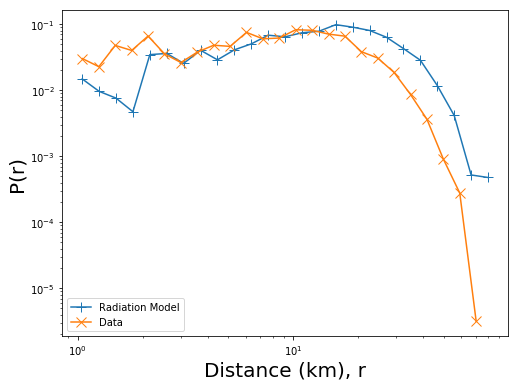

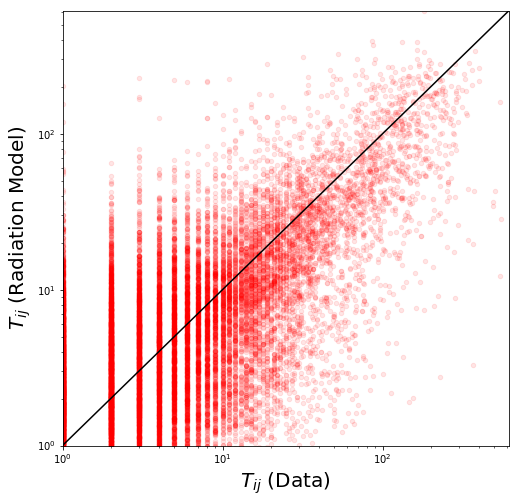

In [11]:
%%time

O = 0.013700 * pop
D = trip_attraction

OD = ExtRadiation()

plt.figure(figsize=(8, 6))
CalcFlows(OD, '+', 'Radiation Model')
CalcFlows(od_census, 'x', 'Data')

plt.figure(figsize=(8,8))
CompareFlows(OD, od_census)

df_OD = pd.DataFrame(OD[:, :3], columns=['origin', 'destination', 'nb_of_trips'])
df_od_census = pd.DataFrame(od_census[:, :3], columns=['origin', 'destination', 'nb_of_trips'])
OD_gb_OD = df_OD.groupby(['origin', 'destination']).first()
od_census_gb_OD = df_od_census.groupby(['origin', 'destination']).first()
joint_ij = pd.merge(OD_gb_OD, od_census_gb_OD, right_index=True, left_index=True).rename(columns={'nb_of_trips_x':'nb_of_trips_OD', 'nb_of_trips_y':'nb_of_trips_od_census'})

CPC3 = CPC(joint_ij.nb_of_trips_od_census, joint_ij.nb_of_trips_OD)
print('CPC =', CPC3)

CPC = 0.6301222832355288
CPU times: user 7.94 s, sys: 55.9 ms, total: 8 s
Wall time: 7.85 s


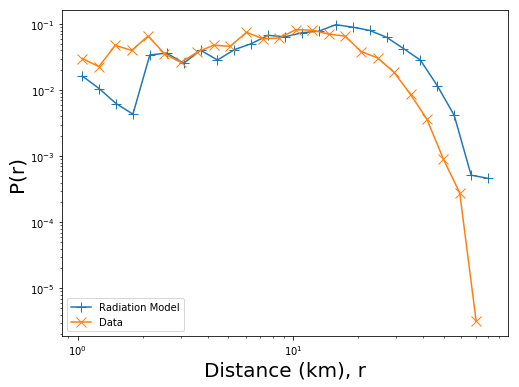

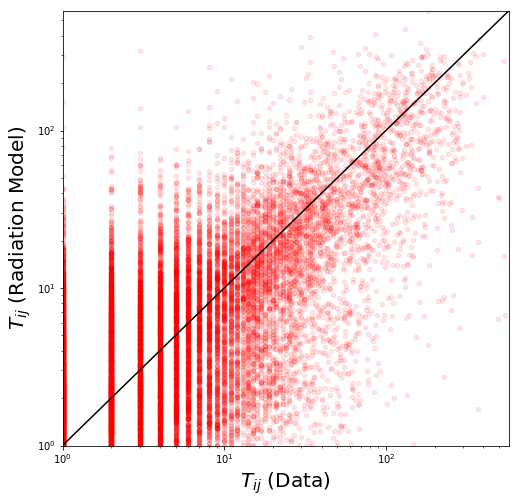

In [12]:
%%time

O = 0.013700 * pop
D = poi

OD = ExtRadiation()

plt.figure(figsize=(8, 6))
CalcFlows(OD, '+', 'Radiation Model')
CalcFlows(od_census, 'x', 'Data')

plt.figure(figsize=(8,8))
CompareFlows(OD, od_census)

df_OD = pd.DataFrame(OD[:, :3], columns=['origin', 'destination', 'nb_of_trips'])
df_od_census = pd.DataFrame(od_census[:, :3], columns=['origin', 'destination', 'nb_of_trips'])
OD_gb_OD = df_OD.groupby(['origin', 'destination']).first()
od_census_gb_OD = df_od_census.groupby(['origin', 'destination']).first()
joint_ij = pd.merge(OD_gb_OD, od_census_gb_OD, right_index=True, left_index=True).rename(columns={'nb_of_trips_x':'nb_of_trips_OD', 'nb_of_trips_y':'nb_of_trips_od_census'})

CPC4 = CPC(joint_ij.nb_of_trips_od_census, joint_ij.nb_of_trips_OD)
print('CPC =', CPC4)

In [13]:
CPC_results = np.array([CPC1, CPC2, CPC3, CPC4])